<a href="https://colab.research.google.com/github/rafaelgmt/exercicios/blob/master/Projeto_APP_SKY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pós-Graduação em Aprendizagem de Máquina em Inteligência Artificial** 
Universidade Presbiteriana Mackenzie

> Disciplina: Aprendizagem de Maquina
Disciplina - *ENLS52033*

> Prof. Gustavo Gattass Ayub

---
**Aluno: Rafael Montenegro**


---


**Nome do Projeto:** Análise das Causas de Reviews Negativas do APP Minha SKY

**Objetivo:** Analisar as principais causas das reviews negativas relatadas pelos usuarios do APP Minha SKY entre  Julho/19 e Agosto/19.

**Dataset:** Reviews publicadas na Apple Store e Google Play

**Técninas utilizadas:** *Text Mining + Modelos de aprendizagem não supervisionados*

---



---

# O projeto foi segmentado em 5 etapas:

> **1º**  Preparar o Google Colab para receber o Dataset

> **2º**  Carregar os pacotes python necessários para o estudo

> **3º**  Analisar o dataset em caráter exploratório

> **4º**  Aplicar Text Mining 

*  *4.1 - Filtering*

*  *4.2 - Tokenization*

*  *4.3 - Stopword Removal*

*  *4.4 - Stemming*

*  *4.5 - Lemmatization*


> **5º**  Aplicar Modelos de aprendizagem não supervisionados (clusterização)

---
# 1º Preparando Google Colab

In [2]:

from google.colab import drive
drive.mount('/drive')
directory = "/drive/My Drive/Projeto_APP_SKY/"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


---
# 2º Carregando os pacotes python

In [33]:
import pandas as pd
import unicodedata
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import webtext
from nltk.corpus import stopwords
nltk.download("stopwords") ## Reaiza download das stopwords incluindo a lingua portuguesa.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
# 3º Analise Exploratória

In [4]:
df_app = pd.read_csv(f"{directory}Projeto_APP_SKY.csv",sep = ",") ## Armazenando o dataset na variavel/dataframe df_app 
df_app.columns ##Avaliando as colunas disponiveis no nosso Dataset - Vamos usar 3 colunas para as analises: Date, Rating e Review

Index(['Date', 'AppID', 'AppName', 'Language', 'Author', 'Rating', 'Title',
       'Review', 'Translated title', 'Translated review', 'Reply Date',
       'Developer Reply', 'User', 'Device', 'Device Type', 'Tags', 'Notes',
       'Link'],
      dtype='object')

---

In [5]:
df_app[["Date","Rating","Review"]].count() 
# Os 3 campos estao completos com 2.650 registros cada
#      - Date representa a data em que o usuário se manifestou na loja do APP
#      - Rating representa a nota de 1 a 5 atribuida pelo usuario
#      - Review refelte o comentário do usuário  

Date      2650
Rating    2650
Review    2650
dtype: int64

---

In [6]:
df_app["Rating"].value_counts()

5    1959
1     378
4     157
3      82
2      74
Name: Rating, dtype: int64

Avaliando a distribuição dos 2.650 registros nota-se que há uma concentração no Rating (Nota de avaiacao) = 5. Totalizando x% da amostra conforme tabela acima. No entanto, o segundo rating com maior participacao na amostra foi o de avaliacao 1. Ou seja, reflete um baixo nivel de satisfacao do usuario totalizando y% da amostra. Vamos criar 3 categorias de rating:

Rating 1 a 2 = Negativo

Rating 3 = Neutro

Rating 4 a 5 = Positivo


In [15]:
df_app.loc[df_app["Rating"] <= 2, "Rating_type"] = "Negativo"
df_app.loc[df_app["Rating"] == 3, "Rating_type"] = "Neutro"
df_app.loc[df_app["Rating"] > 3, "Rating_type"] = "Positivo"
df_app[["Rating_type","Rating"]].groupby("Rating_type").count().sort_values("Rating",ascending=False)

,Rating
Rating_type,
Positivo,2116
Negativo,452
Neutro,82


---


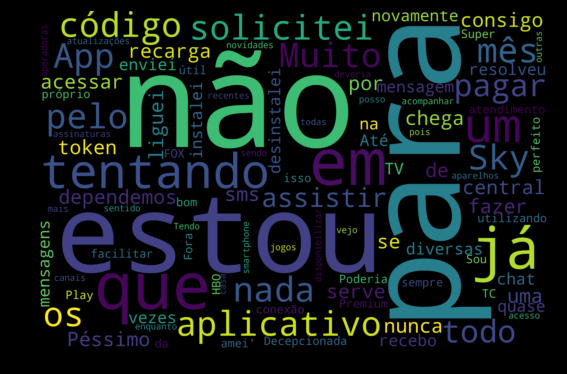

In [34]:
# Rotina para gerar wordcloud do campo Review

text = df_app["Review"].values 
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (15, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Nota-se na WordCloud gerada acima que devido ao não tratamento do Texto (Text Mining) algumas palavras que não agregam valor (preposições por exemplo) acabam sendo exibidas na WordCloud como termos relevantes.
Esse fato reforça ainda mais a importância do Text Mining neste processo de prepação dos dados.**


---
# 4º Text Mining

Antes de iniciar as etapas de Text Mining vamos criar uma coluna nova no dataframe possibilitando a recepção dos tratados (pós text mining) oriundos da coluna Review. Denominaremos essa coluna com o nome de **Review_ajust**

In [0]:
df_app["Review_ajust"] = df_app["Review"].str.lower() #convertendo todas as palavras para lower case

---

> 4.1 **Filtering**

A primeira etapa consiste na remoção dos acentos e caracteres especiais, esses
caracteres de maneira geral não alteram o significado da Review, apesar da remoção da
pontuação poder alterar o significado das frases, no geral a intenção do usuário fica inalterada, o viés do contexto é definido pelas palavras mais significantes e tais caracteres  não tem valor para o seu processamento.


In [0]:
def removerAcentosECaracteresEspeciais(palavra):
    
    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)
  

In [17]:
df_app["Review_ajust"] = df_app["Review_ajust"].apply(removerAcentosECaracteresEspeciais)
df_app[["Date","Rating","Rating_type","Review","Review_ajust"]].head(5)


,Date,Rating,Rating_type,Review,Review_ajust
0,2019-08-17,2,Negativo,Péssimo! estou tentando fazer uma recarga e nã...,pessimo estou tentando fazer uma recarga e nao...
1,2019-08-17,1,Negativo,Para que serve um aplicativo se dependemos de ...,para que serve um aplicativo se dependemos de ...
2,2019-08-17,5,Positivo,amei,amei
3,2019-08-17,5,Positivo,muito bom,muito bom
4,2019-08-17,3,Neutro,mas ou menos,mas ou menos


---

> 4.3 **Stopword Removal**

Textos tem naturalmente um grande volume de dados, o tempo de análise de vários corpos de texto cresce rapidamente, para amenizar o tempo de processamento é necessário diminuir do total de dados que será processado dados que não tem grande valor. Palavras que são muito utilizadas no texto e que não trazem significado direto a uma frase são removidas, tanto para diminuir o corpo do texto e para limitar o conjunto às que trazem mais significado ao corpo de texto, assim as palavras muito frequêntes na escrita são consideradas como de pouco valo e na etapa de stopword removal são removidas, tudo aquilo que não é substantivo, adjetivo ou
verbo é removido.



In [0]:
stop = stopwords.words('portuguese')
df_app["Review_ajust"] = df_app["Review_ajust"].apply( lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
df_app[["Date","Rating","Rating_type","Review","Review_ajust"]].head(5)

,Date,Rating,Rating_type,Review,Review_ajust
0,2019-08-17,2,Negativo,Péssimo! estou tentando fazer uma recarga e nã...,pessimo tentando fazer recarga nao consigo
1,2019-08-17,1,Negativo,Para que serve um aplicativo se dependemos de ...,serve aplicativo dependemos codigo token acess...
2,2019-08-17,5,Positivo,amei,amei
3,2019-08-17,5,Positivo,muito bom,bom
4,2019-08-17,3,Neutro,mas ou menos,menos


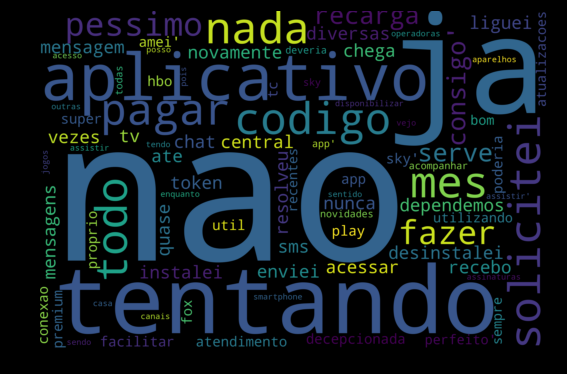

In [35]:
# Rotina para gerar wordcloud do campo Review_ajust, ou seja, após tratamento dos dados

var = 
text = df_app["Review_ajust"].values 
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (15, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [39]:
# Teste Stemming
englishStemmer=SnowballStemmer("portuguese")
englishStemmer.stem("construindo")

'constru'